# Don't be a quitter!
## : Number of Games Played and Win Rate in League of Legends

We have been told and experienced that practicing certain skills are required to achieve success. Yes, we can master the skills through the practice. However, we also doubt that am I really improving my skills while we are performing the repeated actions for the practice. Feeling that hitting the wall is definitely not a delightful experience, and it is also the biggest reason for the losing motivation, which leads to the quitting.

League of Legend is multiplayer on-line game, and approximately 115 million players are playing globally in 2019. The game has tier system, which is divided into 9 different tiers, and it is determined by the performance of player. To explain briefly, player forms team with other 4 players and battle against other team. If your team wins, you gain the points, called league points (LP). Of course, you lose your LP when your team lose. By gathering LP and passing the promotions series, player can increase their tier.

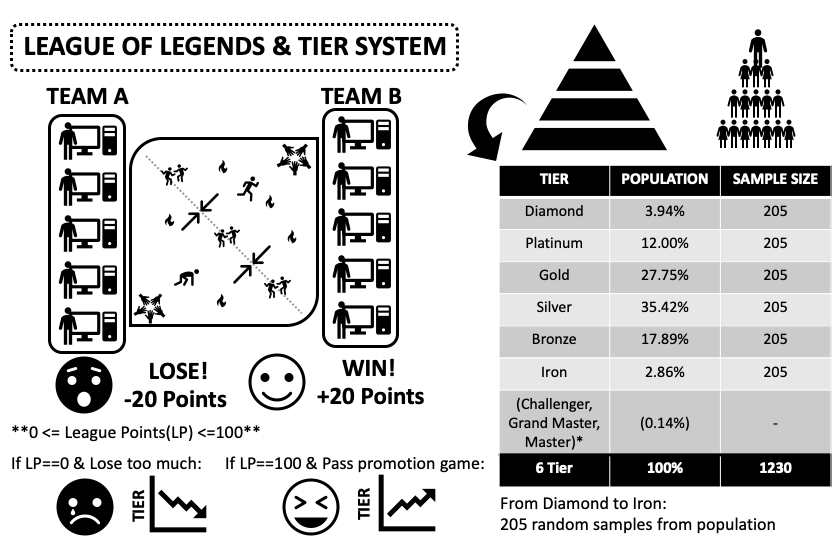

Tier status of player represents the how skilled player is, and most of player wants to increase their tier. Hypothetically, playing huge amount of games with maintaining above 50%-win rate will lead player to top tier. However, without knowing my current status in the game, repetition of game play is just exhausting. Herein, 205 player data is taken from each tier from iron to diamond, and total amount of game and win rate is analyzed.

# Work Flow
Player data is collected by using Riot games Application Programming Interface (API), and received data, .json format, is converted to Pandas DataFrame for the Exploratory data analysis(EDA). Once data is reorganized in Pandas DataFrame, results are stored in .csv file format and stored in PostgreSQL(PSQL). Matplotlib and Seaborn is used for the data visualization.

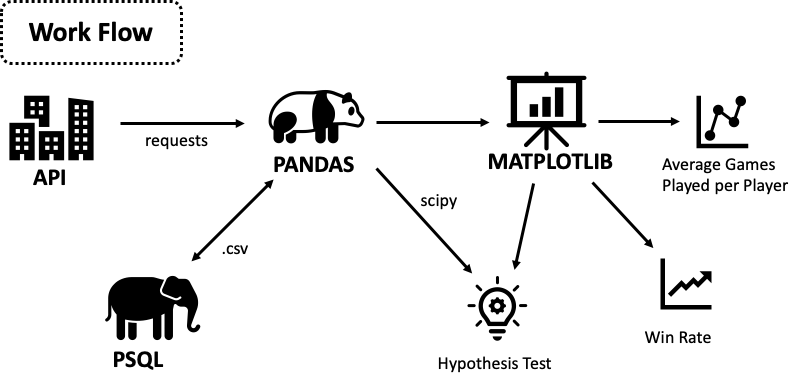

_Command used to store .csv to PSQL_

**Create Table:**
> create table lol_data (freshBlood boolean, hotStreak boolean, inactive boolean, leaguePoints int, losses int, rank varchar, summonerName varchar, tier varchar, veteran boolean, wins int);

**Import .csv to table:**
> \copy lol_data from 'lol_data_(_datetime_).csv' delimiter ',' CSV HEADER

# Importing Packages and Functions

_Following packages and functions are used in this work:_
- requests: User data request and receive
- sleep: API request has rate limiting, so sleep function is imported for the interval request
- pandas: DataFrame used in this work
- json_normalize: Received data format is .json, so it requires the normalization 
- CategoricalDtype: Gives categorical elements sequence and order 
- datetime: Current date time information
- numpy: Calculations
- matplotlib and seaborn: Graphical visualization 
- scipy.stats: Module containing probability distributions and statistical functions

In [1]:
import requests
from time import sleep
import datetime
import pandas as pd   
from pandas.io.json import json_normalize  
from pandas.api.types import CategoricalDtype 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.simplefilter('ignore')

# Define Functions

Since we are requesting the user data from each tier, iteration of the work is unavoidable. Thus, simple function is defined to request and receive data followed by importing data into Pandas DataFrame. Pandas provides convenient function called ‘json_normalize’ to convert .json to Pandas DataFrame.

In [2]:
def get_api_info_division(URL):
    """ 
    API information conversion to Pandas DataFrame.
        - Similar Function to 'get_api_info', but for that requires division information.
        
        1.Receives information from API using requests.
        2.Take entries column from response.json
        3.Normalize the list of dictionaries
        4.Add column total_games and winrate

    Parameters: 
    URL (str): target url for the request (APIKEY included). 
    
    
    Returns: 
    Pandas Dataframe with total_games and winrate column
  
    """
    sleep(1)  # sleep functions is used to prevent exceeding request limit. 
    
    response=requests.get(URL)  # requesting information using API KEY.
    df=json_normalize(response.json()) #Received data format is .json, so it requires the normalization
    
    return df

# Importing API data to Pandas DataFrame

Request URL is saved as a string format and API key, which requires regeneration every 24 hrs, is attached at end of the string.

In [3]:
# APIKEY and URL for Challenger, Grand Master
APIKEY='RGAPI-9584de55-cb4f-4b3f-b872-296422a461a9'
iron_URL='https://na1.api.riotgames.com/lol/league/v4/entries/RANKED_SOLO_5x5/IRON/IV?page=1&api_key='+APIKEY
bronze_URL='https://na1.api.riotgames.com/lol/league/v4/entries/RANKED_SOLO_5x5/BRONZE/I?page=1&api_key='+APIKEY
silver_URL='https://na1.api.riotgames.com/lol/league/v4/entries/RANKED_SOLO_5x5/SILVER/II?page=1&api_key='+APIKEY
gold_URL='https://na1.api.riotgames.com/lol/league/v4/entries/RANKED_SOLO_5x5/GOLD/IV?page=1&api_key='+APIKEY
plat_URL='https://na1.api.riotgames.com/lol/league/v4/entries/RANKED_SOLO_5x5/PLATINUM/IV?page=1&api_key='+APIKEY
dia_URL='https://na1.api.riotgames.com/lol/league/v4/entries/RANKED_SOLO_5x5/DIAMOND/IV?page=1&api_key='+APIKEY

# Merging Datasets by Looping

Received player data from each tier is converted to DataFrames, and these data frames are stored in the list called tier_dfs. tier_names are also stored as a list.

In [4]:
#Forming list for the looping
URL_list = [iron_URL, bronze_URL, silver_URL, gold_URL, plat_URL, dia_URL]

#tier_dfs: list of actual DataFrames.
#tier_name: list of DataFrame names, string type.
tier_dfs=[]
tier_names=['IRON','BRONZE', 'SILVER', 'GOLD', 'PLATINUM', 'DIAMOND']

#Looping to generate list of Dataframes according to each tier
for i in URL_list:
    tier_dfs.append(get_api_info_division(i))


# Looking Through Datasets and Cleaning

Let’s take a brief look on the data set. We collected 205 samples from each tier, and the total number of sample is 1230. 

In [5]:
#Counting number of summoner names in each tier dataframes.
[(tier_names[i],k.summonerName.count())  for i,k in enumerate(tier_dfs)]

[('IRON', 205),
 ('BRONZE', 205),
 ('SILVER', 205),
 ('GOLD', 205),
 ('PLATINUM', 205),
 ('DIAMOND', 205)]

Concatanating DataFrames using pd.concat and displaying column information:
- freshBlood: Newly joined player in the current tier
- veteran: Played more than 100 games in the current tier
- inactive: Not playing for a while
- miniSeries.* data regarding promotion series
- queueType:  only considering 5vs5 solo que type
- hotStreak: winning consecutive streak
- wins and losses: total number count

In [6]:
df=pd.concat(tier_dfs,axis=0, sort=False) #concatenating DataFrames
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1230 entries, 0 to 204
Data columns (total 17 columns):
freshBlood             1230 non-null bool
hotStreak              1230 non-null bool
inactive               1230 non-null bool
leagueId               1230 non-null object
leaguePoints           1230 non-null int64
losses                 1230 non-null int64
miniSeries.losses      49 non-null float64
miniSeries.progress    49 non-null object
miniSeries.target      49 non-null float64
miniSeries.wins        49 non-null float64
queueType              1230 non-null object
rank                   1230 non-null object
summonerId             1230 non-null object
summonerName           1230 non-null object
tier                   1230 non-null object
veteran                1230 non-null bool
wins                   1230 non-null int64
dtypes: bool(4), float64(3), int64(3), object(7)
memory usage: 139.3+ KB


Dropping the unnecessary columns and saving the dataframe as .csv

In [7]:
df.drop(['miniSeries.losses','miniSeries.progress','miniSeries.target','miniSeries.wins', 'leagueId','summonerId','queueType'],axis=1, inplace=True)

#importing datetime function
date=datetime.datetime.now()
ymd=str(date.year)+str(date.month)+str(date.day) #+'_'+str(date.hour)

#Saving the Data with .csv form for SQL storage     
df.to_csv('./data/lol_data_{}.csv'.format(ymd), index=False)

In [8]:
df.head()

,freshBlood,hotStreak,inactive,leaguePoints,losses,rank,summonerName,tier,veteran,wins
0,False,False,False,0,9,IV,TheOnnomise,IRON,False,0
1,False,False,False,64,8,IV,MrMostafa1,IRON,False,1
2,False,False,False,7,158,IV,headlezz2,IRON,True,82
3,False,False,False,64,8,IV,A Fat Baboon,IRON,False,1
4,False,False,False,0,65,IV,Iron Monkeý,IRON,False,19


In [9]:
df.describe()

,leaguePoints,losses,wins
count,1230.000000,1230.000000,1230.000000
mean,36.855285,87.752846,89.865041
std,32.347536,95.704475,98.479967
min,0.000000,2.000000,0.000000
25%,0.000000,19.000000,18.000000
50%,33.000000,55.000000,57.000000
75%,64.000000,118.000000,124.750000
max,100.000000,924.000000,927.000000


In [10]:
df.columns

Index(['freshBlood', 'hotStreak', 'inactive', 'leaguePoints', 'losses', 'rank',
       'summonerName', 'tier', 'veteran', 'wins'],
      dtype='object')

Heatmap displays the correlations between the features. It seems there is no inactive player in this sample set. Interestingly total number of wins and total number of losses show strong correlations.

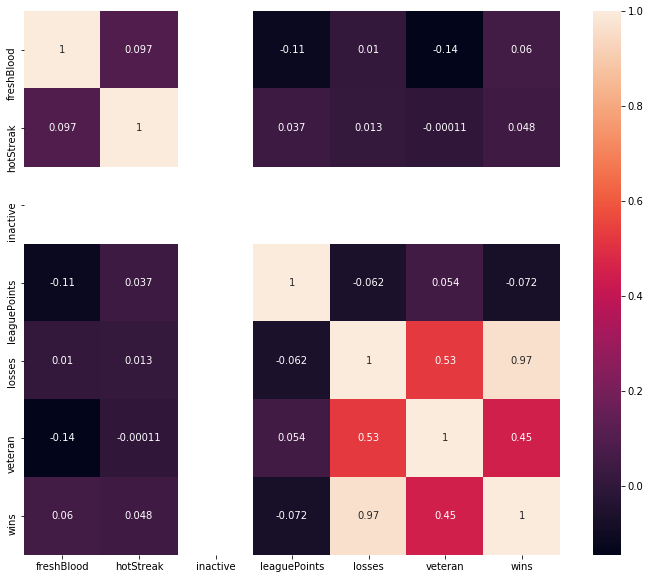

In [11]:
plt.subplots(1,figsize=(12,10))
sns.heatmap(df.corr(),annot=True)

Yes, there is no inactive players in this sample set.

In [12]:
df.inactive.sum(),df.veteran.sum(), df.freshBlood.sum(), df.hotStreak.sum()

(0, 271, 84, 109)

Scatter matrix also shows the tendency of correlation between the features. Since most of columns are consist of Booleans, it is good idea to apply mask in analyzing win rate analysis.

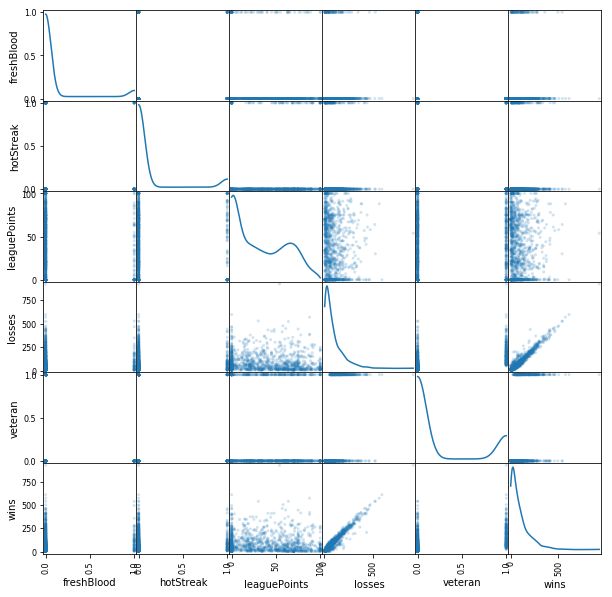

In [13]:
pd.plotting.scatter_matrix(df[['freshBlood', 'hotStreak', 'leaguePoints', 'losses',
       'summonerName', 'tier', 'veteran', 'wins']].applymap(lambda x:x*1), alpha=0.2, figsize=(10, 10), diagonal='kde');

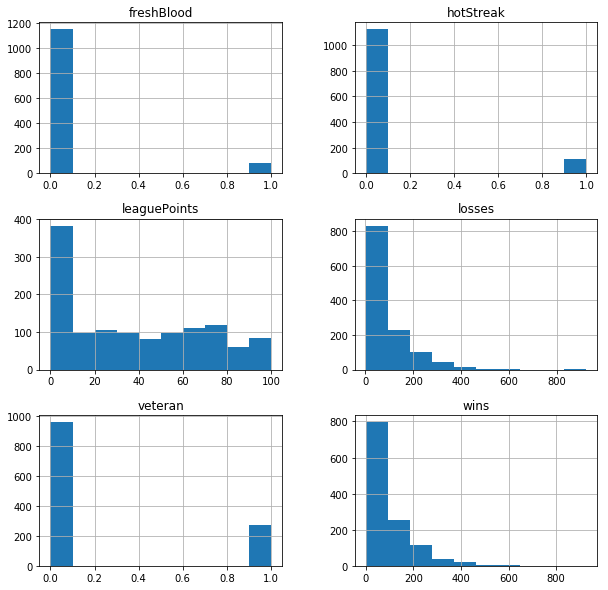

In [14]:
df[['freshBlood', 'hotStreak', 'leaguePoints', 'losses',
       'summonerName', 'tier', 'veteran', 'wins']].applymap(lambda x:x*1).hist(figsize=(10,10));

# Grouping features for analysis

1) Independent Variable: Tier

2) Dependent Variable: Average Number of Games Played per Player in the current season

3) Categories(Filters):
- veteran: played more than 100 games in the current tier
- freshBlood: Newly joined player in the current tier
- normal: not veteran & not freshBlood

In [15]:
#Assigning order on the tier names
tier_type = CategoricalDtype(categories=tier_names, ordered=True)

#grouped by tier and average number of games played per player in the current season
df['total_games']=df.wins+df.losses
df_veteran=df[['total_games', 'tier']][df.veteran].groupby('tier').mean().reset_index()
df_freshBlood=df[['total_games', 'tier']][df.freshBlood].groupby('tier').mean().reset_index()
df_Normal=df[['total_games', 'tier']][~df.veteran&~df.freshBlood].groupby('tier').mean().reset_index()

#Assigning order on the tier groups
df_veteran['tier']=df_veteran['tier'].astype(tier_type)
df_freshBlood['tier']=df_veteran['tier'].astype(tier_type)
df_Normal['tier']=df_veteran['tier'].astype(tier_type)

#setting a tier as an index
df_veteran=df_veteran.sort_values('tier').set_index('tier')
df_freshBlood=df_freshBlood.sort_values('tier').set_index('tier')
df_normal=df_Normal.sort_values('tier').set_index('tier')

#column name changed to veteran, freshBlood and normal
df_veteran.columns=['veteran']
df_freshBlood.columns=['freshBlood']
df_normal.columns=['normal']

#each column merged for the plotting
dfplot=pd.concat([df_veteran, df_freshBlood, df_normal], axis=1)

# Plotting and Analysis

Average Number of Games Played per player in each Tier is shown below. In broad outline, it has a tendency towards number of games played per player increases as their tier increases. Since veterans are the players who played more than 100 games in the current tier, it is obvious that it has high average number of games played compare to freshBlood and normal. Average games played for freshBlood in Silver and Bronze are comparably low due to the fact that most players are placed in Silver and Bronze after the placement tests. 

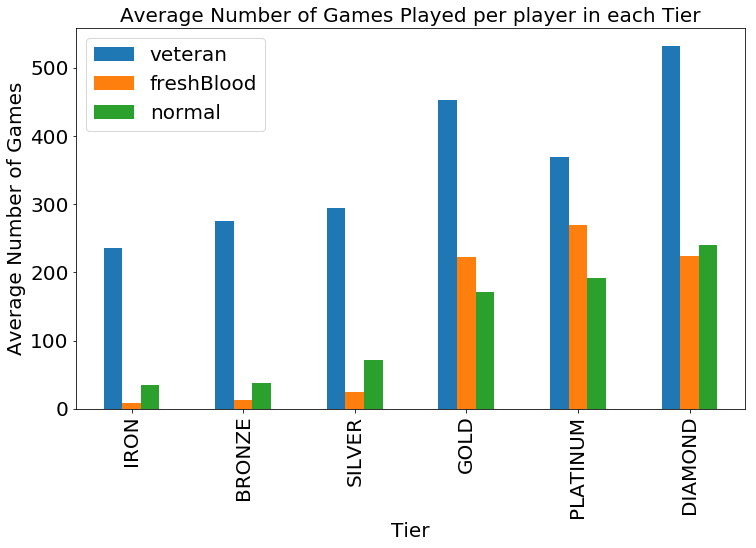

In [16]:
axs=dfplot.plot.bar(figsize=(12,7), fontsize= 25)

# Set title & y-label
axs.set_title('Average Number of Games Played per player in each Tier', fontsize=20)
axs.set_xlabel('Tier', fontsize=20)
axs.set_ylabel('Average Number of Games', fontsize=20)
axs.legend(['veteran', 'freshBlood', 'normal'], fontsize=20)

# Font size setting on each axis
axs.tick_params(axis='both', which='major', labelsize=20)

# Saving Figure .png
plt.savefig('img/avg_games_played_{}.png'.format(ymd), bbox_inches='tight')

Leaving out Silver and Bronze tier players, it is interesting that average games played for freshBloods are higher than normal, which means newly joined player has higher number of games played than the players already in the tier. At glance this does not make sense. How come newly joined player has higher number of games played than normal players? This is because freshBloods are consists of not only promoted player, but also involves demoted players. Considering total number of games increase as tier increases, demoted players are making bias towards the higher numbers.

Normal players are considered as a player who has average skills for the given tier. If they don’t improve their skills, they will stay in this tier and eventually become a veteran. If they improve or worsen their skills, they will become a freshBlood in other tiers. 

Let's take an example for the better understanding:
If you are gold tier and played more than 100 games in this tier, you will be either:
- veteran in gold tier
- freshBlood in other tier (Promotion or Demotion)

What will be a factor that decides your status? Yes, win rate (number of wins / total number of games played). Now let’s take a look on the win rate.


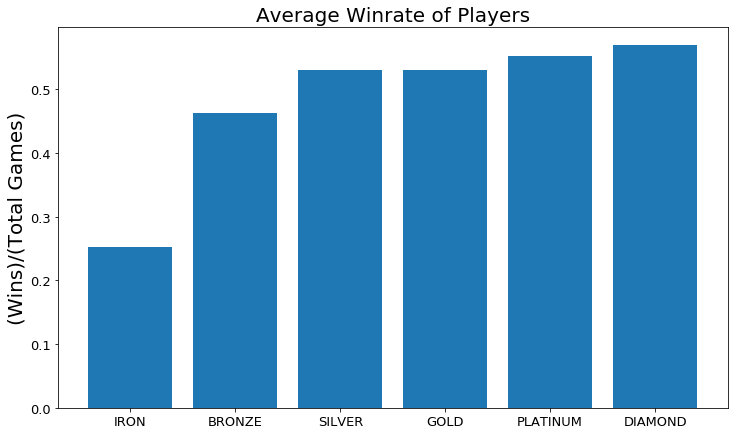

In [17]:
#winrate column added and grouped by tier
df['winrate']=df.wins/df.total_games
gt_mean=df.groupby('tier').mean().reset_index()
gt_mean['tier']=gt_mean['tier'].astype(tier_type)
gt_mean=gt_mean.sort_values('tier')

fig, axs=plt.subplots(1,figsize=(12,7))
axs.bar(gt_mean.tier,gt_mean.winrate)

# Set title & y-label
axs.set_title('Average Winrate of Players', fontsize=20)
axs.set_ylabel('(Wins)/(Total Games)', fontsize=20)

# Font size setting on each axis
axs.tick_params(axis='both', which='major', labelsize=13)

# Saving Figure .png
plt.savefig('img/avg_win_to_lose_{}.png'.format(ymd), bbox_inches='tight')

The plot regarding Average win rate of player for each tier is shown above. As you can see in the bar chart, win rate increases as tier increases. It is also obvious that if you play huge amount of games and maintain the win rate above 50%, your tier will be increased. It’s just matter of time.

# Hypothesis Testing

Matt is gold tier player with 223 win stats from 386 total games. He already played more than few hundred games, and he is feeling miserable that he is only gold. He believes he is better than average gold players and he want to check if this is true.He’s thinking of quitting this game if he is not doing better than average gold players.

> Null Hypothesis: $P(\text{Matt Wins})=P(\text{Average Gold Player Wins})$

In [18]:
gold_mean=df[df.tier=='GOLD'].winrate.mean()
print('Winrate of gold tier : {:2.2f} (win/total games)'.format(gold_mean))

Winrate of gold tier : 0.53 (win/total games)


> Null Hypothesis: $P(\text{Matt Wins})=0.53$

Matt stats= 223 Wins out of 386 Total games

In [19]:
gold_player_tot=386
gold_player_win=223

$$\text{Number of Wins | Null Hypothesis ~ Binomial(n=386, p=0.53)}$$

In [20]:
binomial=stats.binom(gold_player_tot, gold_mean)

He is exhausted and needs the persuading power to make him keep going. He decided to set pretty straightforward rejection threshold, 5%

$$ \alpha = 0.05 $$

In [21]:
#calculate p-value
prob_equal_or_more_extreme = 1 - binomial.cdf(gold_player_win)
print("p-value: {:2.2}".format(
    prob_equal_or_more_extreme))

p-value: 0.028


Interpreting the results, p-value shows probability of the apparent effect under the null hypothesis, and an apparent effect is significant if it is unlikely to have occurred by chance. It’s like a proof by contradiction. P-value is 0.025 which is smaller than rejection threshold. This implies Matt’s wining number does not falls into the gold tier average win rate, which means we can reject the null hypothesis.

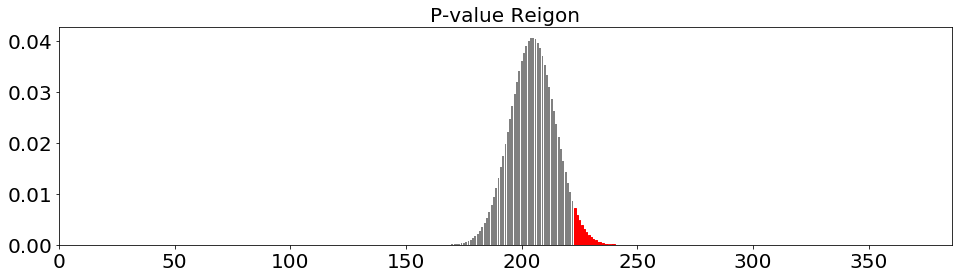

In [22]:
fig, axs = plt.subplots(1, figsize=(16, 4))
#plot binomial distribution
bars = axs.bar(range(gold_player_tot), 
              [binomial.pmf(i) for i in range(gold_player_tot)], 
              color="grey", align="center")
axs.set_xlim(0, gold_player_tot)

#p-value area: red
for i in range(gold_player_win, gold_player_tot):
    bars[i].set_color('red')
    
# Set title & label    
axs.set_title("P-value Reigon", fontsize = 20)
# Font size setting on each axis
axs.tick_params(axis='both', which='major', labelsize=20)

For the clear visualization, binomial distribution is drawn as above, and red area shows the p-value region. He is doing good in gold tier so far and can conclude not to quit the game. He still has a chance to increase tier if he keep improving skills by playing more games.

Slope of line: 1.00
Intercept of line 2.51


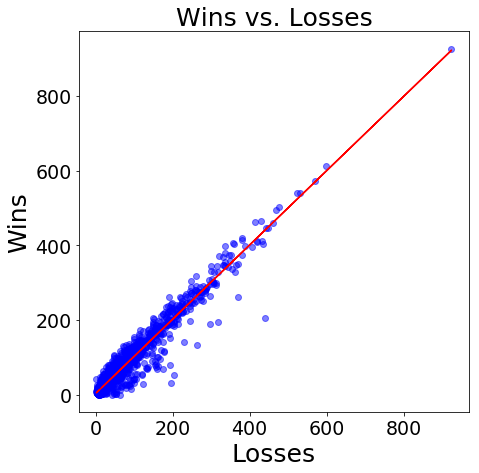

In [23]:
fig, axs=plt.subplots(1,figsize=(7,7))
#plotting losses vs. wins
axs.scatter(df.losses, df.wins, alpha=.5, c ='blue')

#linear fitting using numpy function
a, b = np.polyfit(df.losses,df.wins,1)
linefit=[a*i +b for i in df.losses]
plt.plot(df.losses,linefit, c='r')

#print slope and intercept
print("Slope of line: {:2.2f}".format(a))
print("Intercept of line {:2.2f}".format(b))

# Set title & x,y-label
axs.set_title('Wins vs. Losses', fontsize=25)
axs.set_xlabel('Losses', fontsize=25)
axs.set_ylabel('Wins', fontsize=25)

# Font size setting on each axis
axs.tick_params(axis='both', which='major', labelsize=19)

# Saving Figure .png
plt.savefig('img/avg_win_to_lose_{}.png'.format(ymd), bbox_inches='tight')

The plot shows number of losses vs. number of wins. Regardless of tier status, loss and win shows one to one relationship. Slight improvement of win rate could lead your tier increase, hypothetically, and further study is remained to answer this question.

If your friend is having a hard time playing league of legends, please send him a message or e-mail including these stats and how he is doing. This might help you not losing your friend in league of legends.

# Future Work

Regression analysis using player match records regarding:
- Winning condition: which feature effects most for the winning game?
- Reaching high tier by only playing one champion: Each character has strength, weakness and counter picks. Obviously playing identical character in every game is not the best choice to increase the winning rate. However, there is few players reaching top tier by only playing one champion as known as ‘Artisan’.

In [24]:
import statsmodels.api as sm

In [25]:
y = df['wins']
X = sm.add_constant(df['losses'])

model = sm.OLS(y, X)
wins_losses = model.fit()
wins_losses.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wins   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                 1.794e+04
Date:                Mon, 17 Jun 2019   Prob (F-statistic):               0.00
Time:                        12:45:48   Log-Likelihood:                -5700.5
No. Observations:                1230   AIC:                         1.141e+04
Df Residuals:                    1228   BIC:                         1.142e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5084      0.965      2.599      0.009       0.615       4.402
losses         0.9955      0.007    133.923      0.000       0.981       1.010
==============================================================================
Omnibus:                      608.749   Durbin-Watson:                   0.778
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7819.984
Skew:                          -1.965   Prob(JB):                         0.00
Kurtosis:                      14.711   Cond. No.                         176.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

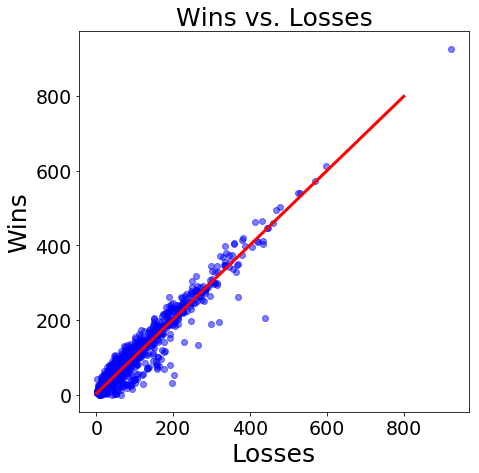

In [26]:
fig, axs=plt.subplots(1,figsize=(7,7))
axs.scatter(df.losses, df.wins, alpha=0.5, color="blue")

x_hat=np.linspace(0,800,1000)
y_hat=wins_losses.params[1]*x_hat+wins_losses.params[0]
axs.plot(x_hat, y_hat, color="red", linewidth=3)


# Set title & y-label
axs.set_title('Wins vs. Losses', fontsize=25)
axs.set_xlabel('Losses', fontsize=25)
axs.set_ylabel('Wins', fontsize=25)

# Font size setting on each axis
axs.tick_params(axis='both', which='major', labelsize=19)

# Saving Figure .png
plt.savefig('img/win_to_lose_{}.png'.format(ymd), bbox_inches='tight')

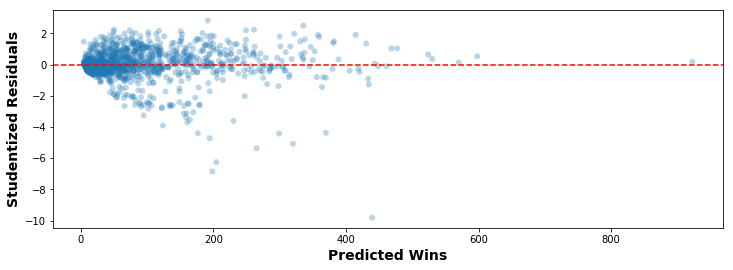

In [27]:
fig, ax = plt.subplots(1, figsize=(12, 4))
student_resid = wins_losses.outlier_test()['student_resid']

ax.scatter(wins_losses.fittedvalues, student_resid, edgecolor='none', alpha=.3)
ax.set_xlabel('Predicted Wins', fontsize=14, fontweight='bold')
ax.set_ylabel('Studentized Residuals', fontsize=14, fontweight='bold')
ax.axhline(0, color='r', linestyle='--')

In [28]:
f_stat, P_value, _ = sm.stats.diagnostic.het_goldfeldquandt(y, X, idx=1, alternative="two-sided")
print(P_value)

5.817437131218705e-87


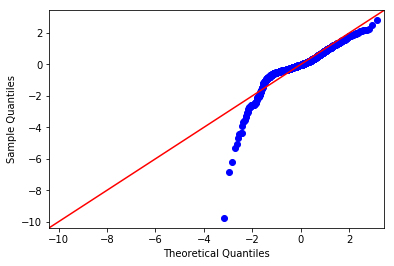

In [29]:
sm.graphics.qqplot(student_resid, line='45', fit=True)
plt.show()

In [30]:
df_not_veteran=df[~df.veteran]

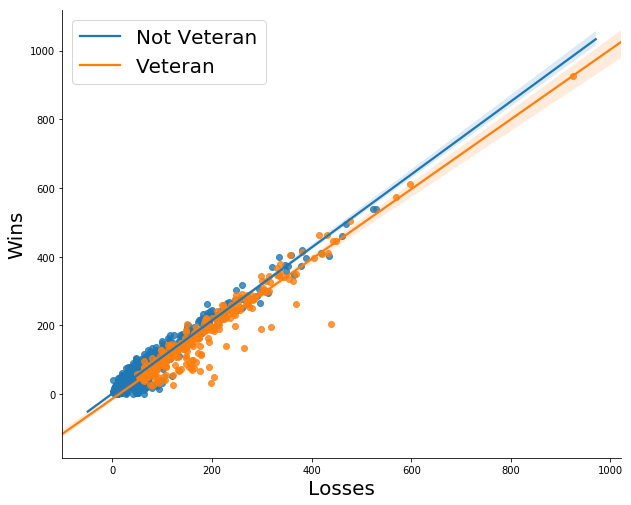

In [31]:
sns.lmplot(x = "losses", y = "wins", hue = "veteran", data=df, height=7, aspect=1.25, legend_out=False)
plt.xlabel('Losses', fontsize=20)
plt.ylabel('Wins', fontsize=20)
plt.legend(['Not Veteran', 'Veteran'], fontsize=20)

Text(3.799999999999997, 0.5, 'Wins')

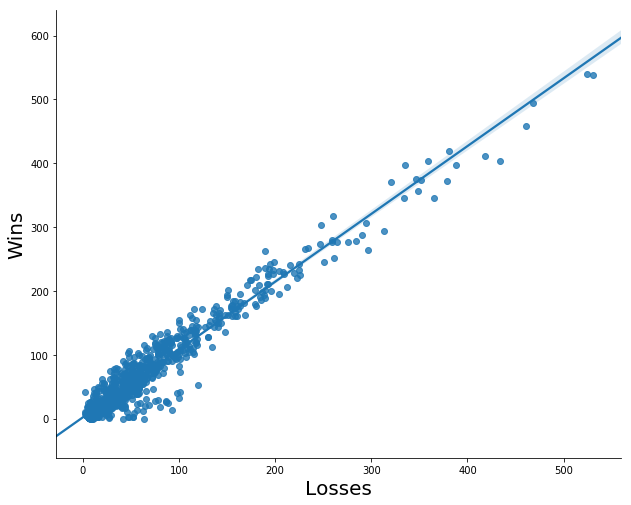

In [32]:
sns.lmplot(x = "losses", y = "wins", data=df_not_veteran, height=7, aspect=1.25, legend_out=False)
plt.xlabel('Losses', fontsize=20)
plt.ylabel('Wins', fontsize=20)

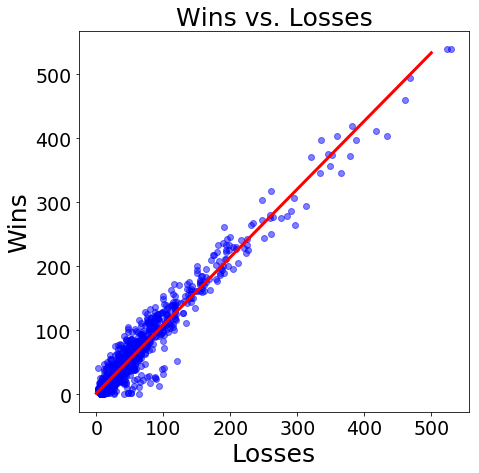

In [33]:
y = df_not_veteran['wins']
X = sm.add_constant(df_not_veteran['losses'])

model = sm.OLS(y, X)
wins_losses = model.fit()
wins_losses.summary()

fig, axs=plt.subplots(1,figsize=(7,7))
axs.scatter(df_not_veteran.losses, df_not_veteran.wins, alpha=0.5, color="blue")

x_hat=np.linspace(0,500,1000)
y_hat=wins_losses.params[1]*x_hat+wins_losses.params[0]
axs.plot(x_hat, y_hat, color="red", linewidth=3)


# Set title & y-label
axs.set_title('Wins vs. Losses', fontsize=25)
axs.set_xlabel('Losses', fontsize=25)
axs.set_ylabel('Wins', fontsize=25)

# Font size setting on each axis
axs.tick_params(axis='both', which='major', labelsize=19)

# Saving Figure .png
plt.savefig('img/wo_veteran_win_to_lose_{}.png'.format(ymd), bbox_inches='tight')

Text(0, 0.5, 'Studentized Residuals')

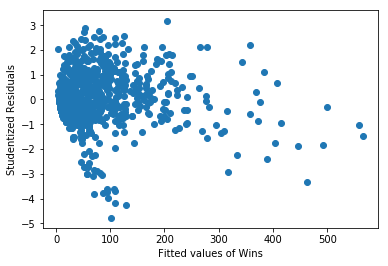

In [34]:
student_resid = wins_losses.outlier_test()['student_resid']
plt.scatter(wins_losses.fittedvalues, student_resid)
plt.xlabel('Fitted values of Wins')
plt.ylabel('Studentized Residuals')

In [35]:
f_stat, P_value, _ = sm.stats.diagnostic.het_goldfeldquandt(y, X, idx=1, alternative="two-sided")

In [36]:
P_value

2.8855360015785494e-54

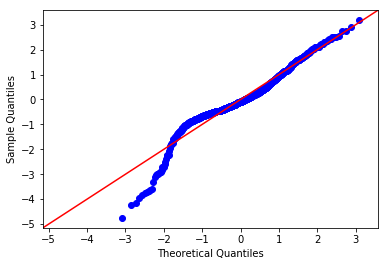

In [37]:
sm.graphics.qqplot(student_resid, line='45', fit=True)
plt.show()